In [5]:
import numpy as np
from scipy.stats import triang
import matplotlib.pyplot as plt

In [97]:
from scipy.stats import triang
def triangle(loc=0, scale=1):
    return triang(c=0.5, loc=-scale + loc, scale=2*scale)

iters = 10_000

theta1_samples = []
theta2_samples = []
theta_1 = 0
for it in range(iters):
    theta_2 = triangle(scale=1-abs(theta_1)).rvs()
    theta_1 = triangle(scale=1-abs(theta_2)).rvs()
    theta1_samples.append(theta_1)
    theta2_samples.append(theta_2)

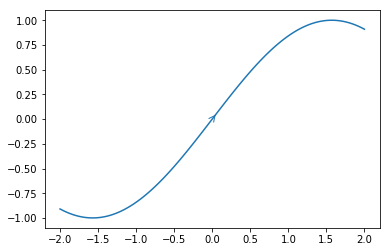

In [71]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


t = np.linspace(-2, 2, 100)
y = np.sin(t)
# return the handle of the line
line = plt.plot(t, y)[0]

add_arrow(line)

plt.show()

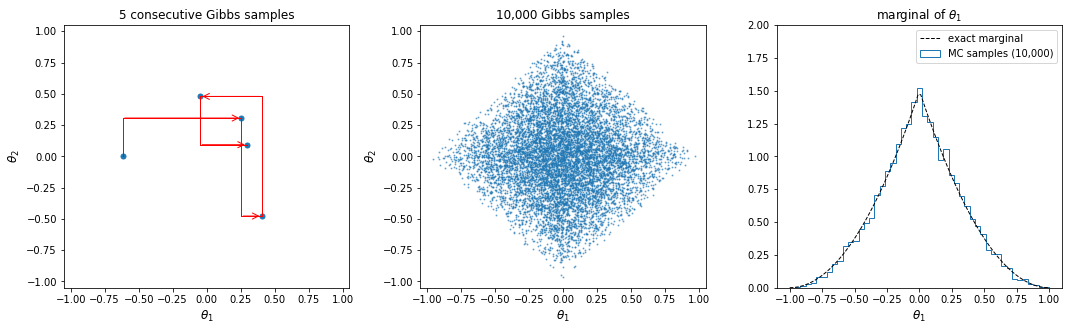

In [96]:
figs, axes = plt.subplots(1,3, figsize=(15,4.7))

ax = axes[0]
start = 45
show = 5
x_show = theta1_samples[start:start+show]
y_show = theta2_samples[start:start+show]
ax.plot(x_show, y_show, '.', ms=10)
for idx in range(0, show-1, 1):
    x_start = x_show[idx]
    x_end = x_show[idx + 1]
    y_start = y_show[idx]
    y_end = y_show[idx + 1]
    ax.plot([x_start, x_start], [y_start, y_end], 'r-', lw=1)
    line = ax.plot([x_start, x_end], [y_end, y_end], 'r-', lw=1)
    add_arrow(line[0])
ax.set_xlabel(r'$\theta_1$', fontsize=12)
ax.set_ylabel(r'$\theta_2$', fontsize=12)
ax.set_xlim([-1.05, 1.05])
ax.set_ylim([-1.05, 1.05])
ax.set_title('5 consecutive Gibbs samples')


ax = axes[1]
ax.plot(theta1_samples, theta2_samples, '.', ms=2, alpha=0.5)
ax.set_xlabel(r'$\theta_1$', fontsize=12)
ax.set_ylabel(r'$\theta_2$', fontsize=12)
ax.set_xlim([-1.05, 1.05])
ax.set_ylim([-1.05, 1.05])
ax.set_title('10,000 Gibbs samples')


ax = axes[2]
ax.hist(theta1_samples, bins=np.linspace(-1,1, 50), histtype='step', density=True, 
        label='MC samples (10,000)')
ax.set_xlabel(r'$\theta_1$', fontsize=12)
x_draw = np.linspace(-1, 1, 100)
ax.plot(x_draw, 3/float(2) * (1 - np.abs(x_draw))**2, 'k--', lw=1, label='exact marginal')
ax.set_title(r'marginal of $\theta_1$')
ax.legend()
ax.set_ylim([0, 2])

plt.tight_layout()

plt.savefig('./08-2d-triangle.pdf', bbox_inches='tight')
plt.show()

In [237]:
import numpy as np
from numpy.random import choice
from scipy.stats import binom, beta, dirichlet

In [176]:
C = 3
clusters = range(3)

p_true = [0.05, 0.4, 0.8]
w_true = [0.5, 0.3, 0.2]
n = 20
N = 20

k_data = []
labels_true = []

for _ in range(N):
    label = choice(clusters, p=w_true)
    k = binom.rvs(n, p_true[label])
    labels_true.append(label)
    k_data.append(k)

In [192]:
k_data

[0, 0, 8, 11, 1, 0, 0, 1, 16, 2, 9, 1, 7, 15, 6, 3, 17, 14, 1, 2]

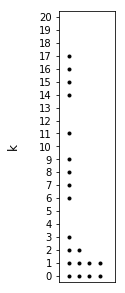

In [477]:
from collections import Counter

c = Counter()
c.update(k_data)

plt.figure(figsize=(1,5))
x = []
y = []
for k, v in c.items():
    y += [k]*v
    x += [n+1 for n in range(v)]
plt.plot(x, y, 'k.')
plt.xlim([0, 5.5])
plt.ylim([-0.5, n + 0.5])
plt.ylabel('k\n', fontsize=12)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks(list(range(n+1)))
plt.savefig('./08-binomial-data.pdf', bbox_inches='tight')
plt.show()

In [235]:
k_sorted = np.array(sorted(k_data))

In [282]:
def sample_labels(k_data, n, w, p):
    labels = []
    for ki in k_data:
        f = w * binom.pmf(ki, n, p)
        f /= np.sum(f)
        labels.append(choice(clusters, p=f))
    return np.array(labels)

def sample_w(labels, clusters):
    alpha = []
    for c in clusters:
        alpha.append(1 + np.sum(labels == c))
    return dirichlet.rvs(alpha)[0]

def sample_p(labels, k_data, n, clusters, alpha0, beta0):
    N = len(k_data)
    p = []
    for c in clusters:
        Kc = np.sum(k_data[labels == c])
        Nc = np.sum(labels == c)
        a = alpha0[c] + Kc
        b = beta0[c] + n*Nc - Kc
        p.append(beta.rvs(a, b))
    return np.array(p)

In [283]:
p = np.array([0.1, 0.5, 0.9])
w = np.array([1./3] * 3 )
labs = sample_labels(k_sorted, n, w, p)
labs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [284]:
sample_w(labs, clusters)

array([0.68191395, 0.21286995, 0.10521609])

In [285]:
alpha0 = np.array([0, 0.5, 1])
beta0 = np.array([1, 0.5, 0])

sample_p(labs, k_sorted, n, clusters, alpha0, beta0)

array([0.0583757 , 0.49551252, 0.83482101])

In [352]:
alpha0 = [0, 0.5, 1]
beta0 = [1, 0.5, 1]

w = np.array([1./3] * 3 )
p = np.array([0.01, 0.5, 0.6])

labels_samples = []
w_samples = []
p_samples = []
iters = 100
for it in range(iters):
    labels = sample_labels(k_sorted, n, w, p)
    w = sample_w(labels, clusters)
    p = sample_p(labels, k_sorted, n, clusters, alpha0, beta0)
    labels_samples.append(labels)
    w_samples.append(w)
    p_samples.append(p)

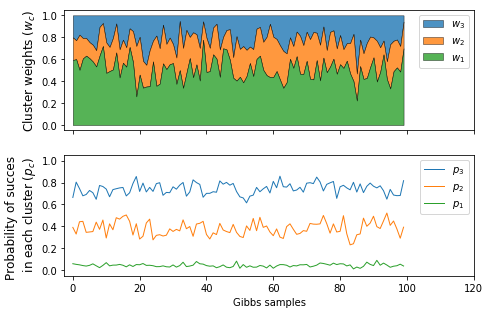

In [445]:
w_samples = np.array(w_samples)
p_samples = np.array(p_samples)


my_colors = ['#246CFF', '#C94DC4', '#DA3333']
fig, axes = plt.subplots(2,1, figsize=(7, 4.5), sharex=True)

ax = axes[0]
high = np.ones_like(w_samples[:,0])
for c, col in zip(clusters[::-1], my_colors):
    ax.fill_between(range(iters), 
                    high - w_samples[:, c], high, lw=0.5, edgecolor='k', alpha=0.8,
            label=r'$w_' + str(c+1) + r'$')
    high -= w_samples[:, c]
ax.legend()
ax.set_ylabel('Cluster weights ($w_c$)', fontsize=12)

ax = axes[1]
for c, col in zip(clusters[::-1], my_colors):
    ax.plot(range(iters), p_samples[:, c], lw=1,
           label=r'$p_' + str(c+1) + r'$')
ax.set_ylabel('Probability of succes \n in each cluster ($p_c$)', fontsize=12)
ax.legend()
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('Gibbs samples')


plt.xlim([-2.5, 120])
plt.tight_layout()

plt.savefig('./08-pw-samples.pdf', bbox_inches='tight')
plt.show()

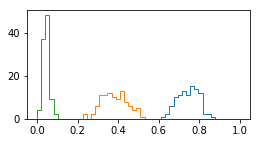

In [446]:
bins = np.linspace(0, 1, 50)
plt.figure(figsize=(4,2))
for c in clusters[::-1]:
    plt.hist(p_samples[:, c], bins=bins, histtype='step')
plt.xlim([-0.05, 1.05])
plt.savefig('./08-p-samples.pdf', bbox_inches='tight')
plt.show()

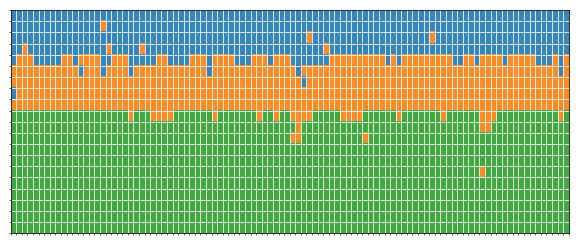

In [476]:
from matplotlib import colors
palette = colors.ListedColormap(['#2ca02c','#ff7f0e','#1f77b4'])

plt.figure(figsize=(10,7))
labels_matrix = np.array(labels_samples).T
plt.imshow(labels_matrix, cmap=palette, aspect=2, origin='lower', alpha=0.9)
ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])

# Minor ticks
ax.set_xticks(np.arange(-.5, 100, 1), minor=True);
ax.set_yticks(np.arange(-.5, 20, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.8)

plt.savefig('./08-labels-samples.pdf', bbox_inches='tight')

plt.show()

In [484]:
mean_p = np.mean(p_samples, axis=0)
mean_w = np.mean(w_samples, axis=0)

In [485]:
mean_p, mean_w

(array([0.04478524, 0.38273419, 0.74404613]),
 array([0.5074357 , 0.26598287, 0.22658143]))

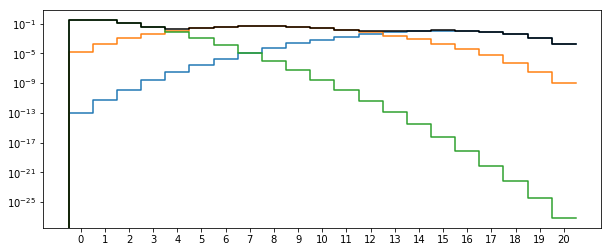

In [514]:
plt.figure(figsize=(10,4))

from collections import Counter

c = Counter()
c.update(k_data)

x = []
y = []
# for k, v in c.items():
#     x += [k]*v
#     y += [n+1 for n in range(v)]
# plt.plot(x, y, 'k.')
# plt.ylim([0.5, 10])
# plt.xlim([-0.5, n + 0.5])

k_draw = np.linspace(-0.5, n+0.5, n+2)
v_draw = []
for c in clusters:
    v_draw.append([0] + list(w[c] * binom.pmf(k_values, n, mean_p[c])))
v_draw = np.array(v_draw)
k_values = list(range(n+1))
for c in clusters[::-1]:
    plt.step(k_draw, v_draw[c,:])

plt.step(k_draw, np.sum(v_draw, axis=0), 'k-') 
plt.yscale('log')

ax = plt.gca()
# ax.set_yticks([])
ax.set_xticks(list(range(n+1)))
plt.show()

In [522]:
total = 1_000_000
counts_draw = []
for c in clusters:
    counts = binom.rvs(n, mean_p[c], size=int(mean_w[c] * total))
    counts_draw.append(counts)

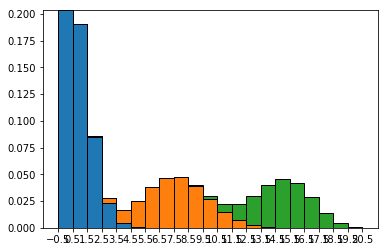

In [528]:
plt.hist(counts_draw, stacked=True, bins=k_draw, lw=1, 
         edgecolor='k', density=True)
ax = plt.gca()
ax.set_xticks(k_draw)
plt.show()

In [530]:
binom.pmf(k_values, n, mean_p[c]).shape

(21,)

In [531]:
k_draw.shape


(22,)

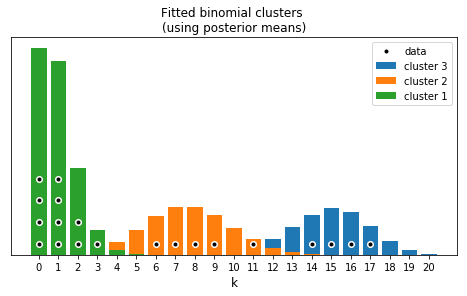

In [557]:

plt.figure(figsize=(8,4))
for c in clusters[::-1]:
    plt.bar(k_values, mean_w[c] * binom.pmf(k_values, n, mean_p[c]),
            label='cluster ' + str(c + 1))

ax = plt.gca()
ylim = ax.get_ylim()
    
    
c = Counter()
c.update(k_data)
x = []
y = []
for k, v in c.items():
    x += [k]*v
    y += [(n+0.5) * ylim[1] / 10 for n in range(v)]
plt.plot(x, y, 'w.', ms=12)
plt.plot(x, y, 'k.', label='data')
    
    
plt.legend()
plt.xlabel('k', fontsize=12)

ax.set_xticks(k_values)
ax.set_yticks([])
plt.title('Fitted binomial clusters \n(using posterior means)')

plt.savefig('./08-binomial-clustering-posterior.pdf', bbox_inches='tight')
plt.show()